In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from scipy.linalg import sqrtm

In [2]:
figsize = (1, 1)

## Generate barbell graph

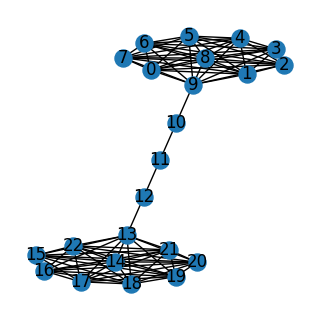

In [3]:
G = nx.barbell_graph(10, 3)

fig = plt.figure(figsize=(3, 3))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, node_size=150, with_labels=True)

## GCN propagation rule

Source: [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)

$H^{l+1} = \sigma(\hat{D}^{-\frac{1}{2}} \hat{A}\hat{D}^{-\frac{1}{2}}X^lW^l)$

where:  
$\hat{A}$ is the adjacency matrix plus the identity matrix $I$  
$\hat{D}$ is the diagonal node degree matrix of $\hat{A}$  
$X\in \mathbb{R}^{Nxd}$ is the matrix of node feature  
$W\in \mathbb{R}^{NxN}$ is the layer weights  
$\sigma$ is non-linear activation functions  

Create adjacency matrix of $G$ (shape: $n x n$, where $n$ is a number of nodes)

### Implementation

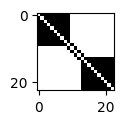

In [4]:
A = nx.adjacency_matrix(G)

fig = plt.figure(figsize=figsize)
plt.imshow(A.todense(), cmap="Greys", interpolation="none");

Create identity matrix $I$ (shape: $n x n$)

In [5]:
I = np.eye(G.number_of_nodes())

Create $\hat{A}$ by adding the self-loop to adjacency matrix $A$

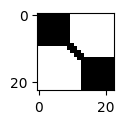

In [6]:
A_hat = A + I

fig = plt.figure(figsize=figsize)
plt.imshow(A_hat, cmap="Greys", interpolation="none");

Create the diagonal node degree matrix $\hat{D}^{-\frac{1}{2}}$

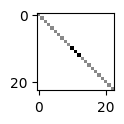

In [7]:
D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.diag(D_hat)
D_hat = np.linalg.inv(sqrtm(D_hat))

fig = plt.figure(figsize=figsize) # in inches
plt.imshow(D_hat, cmap="Greys", interpolation="none");

Normalize adjacency matrix

In [8]:
A_norm = D_hat @ A_hat @ D_hat

### Implement GCN

In [9]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

In [10]:
class GCNLayer():
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = np.tanh
        
    def forward(self, A, X):
        self._X = (A @ X).T
        H = self.W @ self._X
        H = self.activation(H)
        
        return H.T

## Run forward pass

In [13]:
gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)
H1 = gcn1.forward(A_norm, I)
H2 = gcn2.forward(A_norm, H1)
H3 = gcn3.forward(A_norm, H2)

### Result without training

The quite good result without any training.

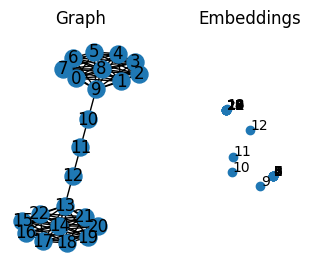

In [14]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(4, 3))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, node_size=150, with_labels=True, ax=axis[0])

axis[0].set_title('Graph')
axis[1].scatter(np.array(H3[:,0]), np.array(H3[:,1]));
axis[1].set_title('Embeddings')

for i, _ in enumerate(H3):
    axis[1].text(np.array(H3[i,0])+0.001, np.array(H3[i,1])+0.001, i)
    
fig.patch.set_visible(False)
axis[1].axis('off')    
plt.margins(1);